In [ ]:
# Imports and Initializations

import portion as P
import numpy as np
import matplotlib.pyplot as plt
import cmath
from parfor import parfor
import csv
filestart='./foodgrad/noise_2_10agents_startfarreverse_plusone_noisy'
filename=filestart+str(np.random.randint(1000))

In [ ]:
# Setting model parameters
v0=2
delv=1
minvel=0
maxvel=4
deltheta=np.pi/8
numagents=10
tau=4
agentradius=1
boundaryradius=40000
thresh=12
numsensors=40
num_timesteps=100

numsamp=50

# Initializing agents
agentsposes=np.random.random(numagents)*20+np.random.random(numagents)*20j-10-10j
agentsdirs=np.random.normal(scale=100*deltheta,size=numagents)%(2*np.pi)+1.25*np.pi
agentsvels=v0*np.ones(numagents)
# agentsposes=np.array([0,20],complex)
# agentsdirs=np.array([0.5,0])
# agentsvels=[v0,0]

# functions related to sensors/boundaries
nprect=np.vectorize(cmath.rect)
# npphase=np.vectorize(cmath.phase)
# agentsposes=nprect(np.abs(agentsposes),npphase(agentsposes)-1.25*np.pi)


def distance_from_circular_boundary(agentpos):
    return boundaryradius-np.abs(agentpos)

def plotboundary(boundaryradius):
    angles=np.linspace(0,2*np.pi,100)
    plt.scatter(np.real(nprect(boundaryradius,angles)),np.imag(nprect(boundaryradius,angles)))

def thetainterval(a,b):
    if abs(b-a)>=2*np.pi:
        return P.closed(0,2*np.pi)
    a=a%(2*np.pi)
    b=b%(2*np.pi)
    if a<=b:
        return P.closed(a,b)
    else:
        return P.closed(a,2*np.pi)|P.closed(0,b)

sensorborders=np.linspace(0,2*np.pi,numsensors+1)
halflensensor=np.pi/(1*numsensors)
sensors=[]
for sensor in range(numsensors):
    sensors.append(thetainterval(sensorborders[sensor],sensorborders[sensor+1]))

def foodfield(i):
    # return 200*np.exp(-np.abs(i)/40)
    return np.imag(i)

def foodgrad(agentpos,agentdir):
    agentback=agentpos-cmath.rect(agentradius/2,agentdir)
    agentfront=agentpos+cmath.rect(agentradius/2,agentdir)
    grad=foodfield(agentfront)-foodfield(agentback)+(np.random.normal(scale=2))
    return grad

In [ ]:
def checkcollisions(agentpos,agent,othersposes): #checks for collisions with other agents
    if numagents>1 and (((np.abs(np.delete(othersposes,agent)-agentpos)).min()<=2*agentradius) or (distance_from_circular_boundary(agentpos)<=1*agentradius)):
        return True
    elif numagents==1 and distance_from_circular_boundary(agentpos)<=1*agentradius:
        return True
    else:
        return False

    
def updatepos(agentpos,agentdir,v):
    return agentpos+cmath.rect(v,agentdir)

def getstate(agentposdir, agent, othersposes,grad):
    # return tuple([0]*numsensors+[grad])
    stateout=[]
    agentpos=agentposdir[0]
    agentdir=agentposdir[1]
    # sensorout=wallinterval(agentpos,agentdir,thresh)
    sensorout=P.empty()
    for others in range(numagents):
        if others==agent:
            continue
        else:
            disp=othersposes[others]-agentpos
            radbydisp=agentradius/abs(disp)
            halfsub=np.arcsin(radbydisp) if radbydisp<1 else np.pi/2
            relthet=(cmath.phase(disp)-agentdir)            
            sensorout=sensorout|thetainterval(relthet-halfsub,relthet+halfsub)
    for sensor in sensors:
        if intervallen(sensorout&sensor)>halflensensor:
            stateout.append(1)
        else:
            stateout.append(0)
    return tuple(stateout+[grad])


def getbest(stateslists):
    outs=[]
    for statelist in stateslists:
        statematrix=np.array(list(set(statelist)),int)
        if statematrix.shape[0]==0:
            score=-1
        else:
            gradmat=statematrix[:,-1]
            statematrix=statematrix[:,:-1]
            score=(((statematrix.shape[1]-statematrix@statematrix.T-(1-statematrix)@(1-statematrix).T).sum(axis=1)/(statematrix.shape[0])+1).flatten())@(maxvel*tau+1+(gradmat)).flatten()
        outs.append(score)
    return randargmax(np.array(outs))
    
def randargmax(b):
    return np.random.choice(np.where(b == b.max())[0])
    
def intervallen(inter):
    length=0
    for i in inter:
        length+=i.upper-i.lower
    return length

def findposesovertime(agentsposes,agentsdirs,agentsvels,tau):
    posesovertime=[]
    posesovertime.append(agentsposes)
    newposes=agentsposes.copy()
    newdirs=agentsdirs.copy()
    for i in range(tau):
        newposes=newposes+nprect(agentsvels,newdirs)
        for agent in range(numagents):
            newposes[agent],newdirs[agent]=reflect_circularwall(newposes[agent],newdirs[agent],0)
        posesovertime.append(newposes.copy())
    return posesovertime

def reflect_circularwall(pos,dir,dep):
    if distance_from_circular_boundary(pos)>1*agentradius:
        return pos,dir
    else:
        xa,ya=np.real(pos),np.imag(pos)
        if not(np.isclose(dir,np.pi/2) or np.isclose(dir,3*np.pi/2)):
            a=1+(np.tan(dir))**2
            b=-2*np.tan(dir)*(xa*np.tan(dir)-ya)
            c=ya**2+(xa*np.tan(dir))**2-2*ya*xa*np.tan(dir)-(boundaryradius-1*agentradius)**2
            x1=(-b-(b**2-4*a*c)**0.5)/(2*a)
            y1=np.tan(dir)*(x1-xa)+ya
            x2=(-b+(b**2-4*a*c)**0.5)/(2*a)
            y2=np.tan(dir)*(x2-xa)+ya
        else:
            x1=xa
            x2=xa
            y1=((boundaryradius-1*agentradius)**2-xa**2)**0.5
            y2=-y1
        distances=np.array([(xa-x1)**2+(ya-y1)**2,(xa-x2)**2+(ya-y2)**2])
        minind=np.argmin(distances)
        xp,yp=[(x1,y1),(x2,y2)][minind]
        distance=(distances[minind])**0.5
        if dep<3:
            newdir=(-1*dir+2*cmath.phase(xp+1j*yp)+np.pi)%(2*np.pi)
        else:
            newdir=(-1*dir+3*cmath.phase(xp+1j*yp)+(1)*np.pi)%(2*np.pi)
        newpos=xp+1j*yp+cmath.rect(distance,newdir)
        return reflect_circularwall(newpos,newdir,dep+1)

def rightdiff(a,b):
    if b>a:
        return a+2*np.pi-b
    else: return a-b

def wallinterval(agentpos,agentdir,thresh):
    dist=distance_from_circular_boundary(agentpos)
    if dist>=thresh:
        return P.empty()
    else:
        x0,y0=(np.real(agentpos),np.imag(agentpos))
        R=boundaryradius
        a=x0**2+y0**2
        b=-1*x0*(a-thresh**2+R**2)
        c=((a-thresh**2+R**2)/2)**2-(y0*R)**2
        x1=(-b+(b**2-4*a*c)**0.5)/(2*a)
        if np.isclose(y0,0):
            if x0>0:
                y1=-1*(R**2-x1**2)**0.5
            else:
                y1=1*(R**2-x1**2)**0.5
        else:
            y1=((a-thresh**2+R**2)/2-x1*x0)/y0

        theta1=(cmath.phase(x1+y1*1j-agentpos))%(2*np.pi)
        theta0=(cmath.phase(agentpos))%(2*np.pi)
        deltheta=rightdiff(theta0,theta1) if (theta0<=np.pi or np.isclose(theta0,2*np.pi)) else -rightdiff(theta1,theta0)
        if (theta0<=np.pi or np.isclose(theta0,2*np.pi)):
            return thetainterval(theta1-agentdir,theta1+2*deltheta-agentdir)
        else:
            return thetainterval(theta1+2*deltheta-agentdir,theta1-agentdir)

def make_moveset(agentpos,agentdir,v):
    dircombs=[(agentdir+2*deltheta)%(2*np.pi),(agentdir+deltheta)%(2*np.pi),agentdir,(agentdir-deltheta)%(2*np.pi),(agentdir-2*deltheta)%(2*np.pi)]
    tempvelcombs=[v-delv,v,v+delv]
    velcombs=[]
    for vel in tempvelcombs:
        if vel>=minvel and vel<=maxvel:
            velcombs.append(vel)
    moveset=[]
    for vel in velcombs:
        for dir in dircombs:
            moveset.append([vel,dir])
    return moveset

def randevolve(numsamp,agentpos,agentdir, agent, othersposesovertime, move, k,tau,velprobs,thetprobs,agentgrad):
    #k is not used, can be removed
    
    ogdir=agentdir
    ogpos=agentpos
    v=move[0]
    othersposes=othersposesovertime[1]
    newagentdir=(move[1])%(2*np.pi)
    newagentposdir=[updatepos(agentpos,newagentdir,v),newagentdir]
    outposes=[]
    if not(checkcollisions(newagentposdir[0],agent,othersposes)):
        outposes.append(getstate(newagentposdir,agent,othersposes,(np.abs(newagentposdir[0]-ogpos))*np.sign(agentgrad*np.cos(newagentposdir[1]-ogdir))))
        for samp in range(numsamp):
            vel=v
            pos,dir=newagentposdir
            for t in range(2,tau+1):
                newvel=vel+np.random.choice([0,-delv,delv],p=velprobs)
                newdir=(dir+np.random.choice([0,-deltheta,deltheta,2*deltheta,-2*deltheta],p=thetprobs))%(2*np.pi)
                if newvel>maxvel or newvel<minvel:
                    newvel=vel
                newpos=updatepos(pos,newdir,newvel)
                if not(checkcollisions(newpos,agent,othersposesovertime[t])):
                    pos=newpos
                    dir=newdir
                    vel=newvel
                    outposes.append(getstate([pos,dir],agent,othersposesovertime[t],(np.abs(pos-ogpos))*np.sign(agentgrad*np.cos(dir-ogdir))))
                else:
                    break
        return outposes            
    else:
        return []

In [ ]:
file=open(filename+'.csv','a')
writer=csv.writer(file)
xlocs=np.real(agentsposes)
ylocs=np.imag(agentsposes)
plt.figure()
plt.gca().set_aspect(1)
# plotboundary(boundaryradius)
plt.scatter(np.real(agentsposes),np.imag(agentsposes),c=range(numagents),cmap='gist_ncar',vmin=0,vmax=numagents)
writer.writerow(list(agentsposes))
writer.writerow(list(agentsdirs))
for i in range(numagents):
    dir=cmath.rect(1,agentsdirs[i])
    plt.arrow(xlocs[i],ylocs[i],3*np.real(dir),3*np.imag(dir))
plt.savefig(filename+'_'+str(0)+'.png',facecolor='white')
plt.close()


for time in range(num_timesteps):
    agentsposesovertime=findposesovertime(agentsposes,agentsdirs,agentsvels,tau)
    agentsposes=agentsposesovertime[0]
    print(time)
    chosenmoves=[]
    @parfor(range(numagents))
    def paragent(focal):
        stateslists=[]
        agentpos=agentsposes[focal]
        agentdir=agentsdirs[focal]
        agentvel=agentsvels[focal]
        moveset=make_moveset(agentpos,agentdir,agentvel)
        agentgrad=foodgrad(agentpos,agentdir)
        for move in moveset:
            evolvelist=randevolve(numsamp,agentpos,agentdir,focal,agentsposesovertime,move,1,tau,[1/3]*3,[1/5]*5,agentgrad)
            stateslists.append(evolvelist)
        chosen=getbest(stateslists)
        return moveset[chosen]
    chosenmoves=paragent
    for updateagent in range(numagents):
        newpos=updatepos(agentsposes[updateagent],chosenmoves[updateagent][1],chosenmoves[updateagent][0])
        if np.abs(newpos)>boundaryradius-agentradius:
            newpos=agentsposes[updateagent]
        agentsposes[updateagent]=newpos
        agentsdirs[updateagent]=chosenmoves[updateagent][1]
        agentsvels[updateagent]=chosenmoves[updateagent][0]
    xlocs=np.real(agentsposes)
    ylocs=np.imag(agentsposes)
    writer.writerow(chosenmoves)
    writer.writerow(list(agentsposes))
    writer.writerow(list(agentsdirs))
    plt.figure()
    # plotboundary(boundaryradius)
    plt.gca().set_aspect(1)
    plt.scatter(xlocs,ylocs,c=range(numagents),cmap='gist_ncar',vmin=0,vmax=numagents)
    # plt.plot((0,5),(0,5))
    for i in range(numagents):
        dir=cmath.rect(1,agentsdirs[i])
        plt.arrow(xlocs[i],ylocs[i],3*np.real(dir),3*np.imag(dir))
    plt.savefig(filename+'_'+str(time+1)+'.png',facecolor='white')
    plt.close()
file.close()

In [5]:
# import matplotlib
# fig, ax = plt.subplots()
# x=np.real(agentsposes)
# y=np.imag(agentsposes)
# plt.xlim(-40,40)
# plt.ylim(-40,40)
# plt.gca().set_aspect(1)
# cmap = matplotlib.colormaps['tab10']
# circles = [plt.Circle((xi,yi), radius=1,facecolor='green') for xi,yi in zip(x,y)]
# # c = matplotlib.collections.PatchCollection(circles)
# for i in range(len(circles)):
#     circles[i].set_facecolor(cmap(i))
#     ax.add_patch(circles[i])
# for s in sensorborders:
#     plt.plot([-40,40],np.tan(s+agentsdirs[0])*(np.array([-40,40])-np.real(agentsposes[0]))+np.imag(agentsposes[0]))
# plt.plot([-40,40],np.tan(s+agentsdirs[0])*(np.array([-40,40])-np.real(agentsposes[0]))+np.imag(agentsposes[0]),'g')

In [18]:
focal=0



agentpos=(98.46301022030626+13.944881193539159j)
agentdir=4.272828933
agentvel=3
agentgrad=foodgrad(agentpos,agentdir)
moveset=make_moveset(agentpos,agentdir,agentvel)
agentsposesovertime=findposesovertime(agentsposes,agentsdirs,agentsvels,tau)
getbest([randevolve(numsamp,agentpos,agentdir,focal,agentsposesovertime,moveset[i],1,tau,[1/3]*3,[1/5]*5,agentgrad) for i in range(len(moveset))])

(4,
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [16]:
[(moveset[i][1]*180/np.pi,i) for i in range(len(moveset))]

[(289.8150644422868, 0),
 (267.31506444228677, 1),
 (244.81506444228683, 2),
 (222.31506444228683, 3),
 (199.81506444228683, 4),
 (289.8150644422868, 5),
 (267.31506444228677, 6),
 (244.81506444228683, 7),
 (222.31506444228683, 8),
 (199.81506444228683, 9),
 (289.8150644422868, 10),
 (267.31506444228677, 11),
 (244.81506444228683, 12),
 (222.31506444228683, 13),
 (199.81506444228683, 14)]

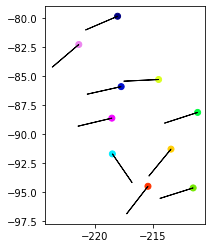

In [9]:
    xlocs=np.real(agentsposes)
    ylocs=np.imag(agentsposes)
    plt.gca().set_aspect(1)
    plt.scatter(xlocs,ylocs,c=range(numagents),cmap='gist_ncar',vmin=0,vmax=numagents)
    for i in range(numagents):
        dir=cmath.rect(1,agentsdirs[i])
        plt.arrow(xlocs[i],ylocs[i],3*np.real(dir),3*np.imag(dir))

In [17]:
    agentpos=agentsposes[foc]
    agentdir=agentsdirs[foc]
    agentback=agentpos-cmath.rect(agentdir,agentradius/2)
    agentfront=agentpos+cmath.rect(agentdir,agentradius/2)
    grad=foodfield(agentfront)-foodfield(agentback)

In [19]:
agentfront, agentback

((-58.98124807330445-76.48054240998893j),
 (-65.39722575760396-79.98560699370394j))

In [1]:
from glob import glob
import csv
import matplotlib.pyplot as plt
import numpy as np


def getdata(globthing,ignorelen):
    veldir=[]
    lastpos=[]
    listname=glob(globthing)
    print(len(listname), 'files')
    for filename in listname:
        with open(filename,'r') as file:
            data=list(csv.reader(file))
        l1=[]
        for i in data[2::3]:
            l2=[]
            for j in i:
                l2.append(eval(j))
            l1.append(l2)
        veldir+=l1[ignorelen:]
        lastpos+=data[-2]
    veldir=sum(veldir,[])
    veldir=np.array(veldir)
    lastpos=np.array(lastpos).astype(complex)
    return veldir,lastpos

(array([0.00750027, 0.05652985, 0.11389306, 0.15653352, 0.16083923,
        0.18278448, 0.18014549, 0.15875582, 0.19472936, 0.03833474]),
 array([-3.99971825e+00, -3.19974758e+00, -2.39977691e+00, -1.59980624e+00,
        -7.99835570e-01,  1.35100275e-04,  8.00105771e-01,  1.60007644e+00,
         2.40004711e+00,  3.20001778e+00,  3.99998845e+00]),
 <BarContainer object of 10 artists>)

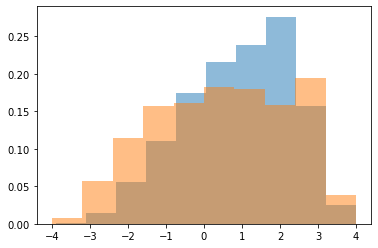

In [3]:
plt.hist(inter[:,0]*np.sin(inter[:,1]),alpha=0.5,density=1)
plt.hist(nointer[:,0]*np.sin(nointer[:,1]),alpha=0.5,density=1)

10 files
10 files


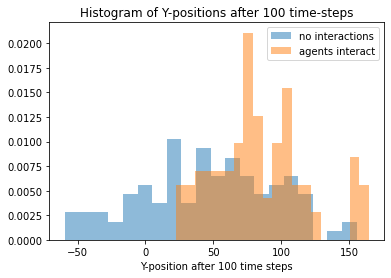

In [26]:
plt.hist(np.imag(getdata('./foodgrad/noint*.csv',20)[1]),20,density=1,alpha=0.5,label='no interactions')
plt.hist(np.imag(getdata('./foodgrad/nois*.csv',20)[1]),20,density=1,alpha=0.5,label='agents interact')
plt.legend()
plt.xlabel('Y-position after 100 time steps')
plt.title('Histogram of Y-positions after 100 time-steps')
plt.savefig('./illustrations/gradhist.png',facecolor='white',bbox_inches='tight',dpi=200)
# plt.hist(np.imag(getdata('./foodgrad/lessturn_noint*.csv',20)[1]),20,density=1,alpha=0.5)
# plt.hist(np.imag(getdata('./foodgrad/lessturn_nois*.csv',20)[1]),20,density=1,alpha=0.5)

10 files
10 files
10 files
10 files


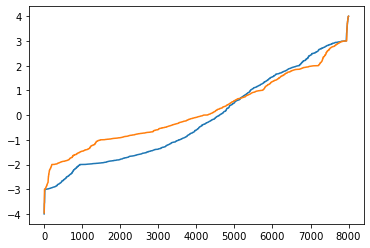

In [22]:
plt.plot(np.sort(np.sin(getdata('./foodgrad/lessturn_noint*.csv',20)[0][:,1])*getdata('./foodgrad/lessturn_noint*.csv',20)[0][:,0]))
plt.plot(np.sort(np.sin(getdata('./foodgrad/lessturn_nois*.csv',20)[0][:,1])*getdata('./foodgrad/lessturn_nois*.csv',20)[0][:,0]))

In [18]:
getdata('./foodgrad/noint*.csv',20)[0][:,1]

10 files


array([5.7679626 , 5.69773193, 0.00686351, ..., 1.1902556 , 0.61670029,
       2.0766635 ])

(array([ 9.,  4.,  7.,  0.,  0.,  0., 12., 15., 43., 10.]),
 array([-1.73632515e+01, -8.16324859e-02,  1.71999866e+01,  3.44816056e+01,
         5.17632247e+01,  6.90448437e+01,  8.63264628e+01,  1.03608082e+02,
         1.20889701e+02,  1.38171320e+02,  1.55452939e+02]),
 <BarContainer object of 10 artists>)

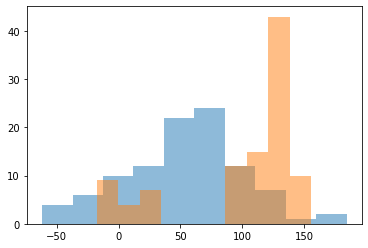

In [132]:
plt.hist(np.sort(np.imag(np.array(l3).astype(complex))),alpha=0.5)
plt.hist(np.sort(np.imag(np.array(l4).astype(complex))),alpha=0.5)

In [130]:
np.sort(np.imag(np.array(l4).astype(complex))).mean()

99.13730416023844

In [20]:
l1=[]
for i in data:
    l2=[]
    for j in i:
        l2.append(eval(j))
    l1.append(l2)

In [143]:
len(l4)

9000

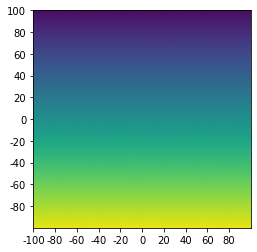

In [112]:
xs=np.linspace(-100,100,10000)
ys=np.linspace(-100,100,10000)
plt.xticks(range(0,1100,100),range(-100,120,20))
plt.yticks(range(0,1100,100),range(100,-120,-20))
plt.imshow(z)



In [113]:
x,y=np.meshgrid(xs,ys)

In [114]:
z=y+np.random.normal(scale=2,size=y.shape)

In [109]:
z.shape

(1000, 1000)

In [140]:
ls=[]
for k in range(100000):
    xa=np.random.randint(990)
    ya=np.random.randint(1000)
    ls.append(z[xa+50,ya]-z[xa,ya])

(array([1.25095166e-03, 1.25095166e-03, 3.61386035e-03, 6.39375292e-03,
        1.22315273e-02, 1.98762319e-02, 3.19687646e-02, 4.80921415e-02,
        6.82463627e-02, 9.00685194e-02, 1.13697606e-01, 1.34268811e-01,
        1.39828596e-01, 1.45249387e-01, 1.29681989e-01, 1.20925327e-01,
        9.81302079e-02, 7.33891639e-02, 5.96286957e-02, 3.65555873e-02,
        2.37680815e-02, 1.58453877e-02, 8.47867235e-03, 3.19687646e-03,
        2.64089795e-03, 5.55978515e-04, 5.55978515e-04, 1.38994629e-04,
        1.38994629e-04, 2.77989257e-04]),
 array([-8.40236913, -7.68291687, -6.96346461, -6.24401234, -5.52456008,
        -4.80510782, -4.08565556, -3.3662033 , -2.64675103, -1.92729877,
        -1.20784651, -0.48839425,  0.23105801,  0.95051027,  1.66996254,
         2.3894148 ,  3.10886706,  3.82831932,  4.54777158,  5.26722385,
         5.98667611,  6.70612837,  7.42558063,  8.14503289,  8.86448516,
         9.58393742, 10.30338968, 11.02284194, 11.7422942 , 12.46174647,
        13.18119

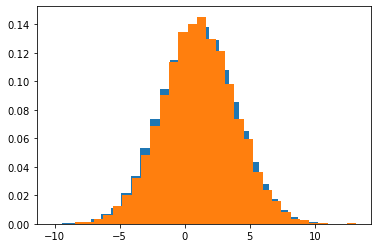

In [141]:
plt.hist(ls,30,density=1)
plt.hist(np.random.normal(1,size=10000,scale=2*2**0.5),30,density=1)

In [138]:
(np.array(ls)<0).sum()/len(ls)

0.1451

In [120]:
sum(ls)/len(ls)

0.9952588257760472

(array([3.15328413e-05, 4.72992619e-04, 4.06773653e-03, 2.27667114e-02,
        6.33494782e-02, 9.77833408e-02, 8.19853874e-02, 3.51275852e-02,
        8.19853874e-03, 1.54510922e-03]),
 array([-17.06270494, -13.8914081 , -10.72011125,  -7.54881441,
         -4.37751757,  -1.20622073,   1.96507611,   5.13637296,
          8.3076698 ,  11.47896664,  14.65026348]),
 <BarContainer object of 10 artists>)

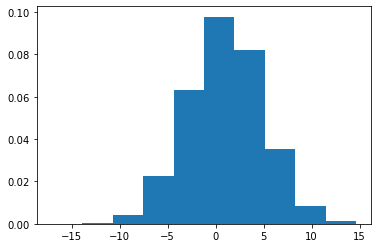

In [101]:
plt.hist(np.random.normal(1,size=10000,scale=4),density=1)

In [139]:
2*2**0.5

2.8284271247461903

In [144]:
import scipy
scipy.stats.norm.cdf(0,loc=1,scale=2*2**0.5)

0.36183680491588155

In [3]:
import numpy as np
k=np.array([[1,2,3,4]]).T

In [11]:
k=k.reshape(-1,1)

In [12]:
k

array([[1],
       [2],
       [3],
       [4]])

In [23]:
position=np.array([[1,2],[3,4],[5,6],[7,8]])
x=position[:,0].reshape(-1,1)

In [24]:
dx=x-x.T

In [25]:
L=5

In [32]:
dx - np.round(dx / L) * L

array([[ 0., -2.,  1., -1.],
       [ 2.,  0., -2.,  1.],
       [-1.,  2.,  0., -2.],
       [ 1., -1.,  2.,  0.]])

In [31]:
dx-np.round(dx/L)*L

array([[ 0., -2.,  1., -1.],
       [ 2.,  0., -2.,  1.],
       [-1.,  2.,  0., -2.],
       [ 1., -1.,  2.,  0.]])

In [37]:
d=np.arange(0,10,0.1)
d-np.round(d/L)*L

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8,
       -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7,
       -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,
        0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,
        1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4, -2.5, -2.4,
       -2.3, -2.2, -2.1, -2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3,
       -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2,
       -0.1])

In [41]:
np.where(np.array([[1,2,3],[1,2,3]])==4)

(array([], dtype=int64), array([], dtype=int64))